# Chapitre 1
Ce TP a pour objectif de vous familiariser avec le workflow classique de traitement d'une tâche NLP. Il aborde les points suivants :  
* Analyse exploratoire du dataset avec pandas  
* Familiarisation avec les concepts principaux de preprocessings  
  * Tokenisation  
  * Suppression des stopwords  
  * Lemmatisation/Stemming  
* Utilisation d'une représentation Bag of Words pour une tâche de classification simple  
* Introduction au topic modeling avec LDA  

## Outils et concepts :  
* pandas  
* nltk  
* spacy  
* scikit-learn  
* gensim  

# Installations et imports

In [2]:
pip install -q datasets

In [3]:
!python -m spacy download fr_core_news_md
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 9.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import nltk as nltk
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()
nltk.download('punkt')
import spacy

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Téléchargement des données

In [5]:
amazon = r'/content/drive/MyDrive/TP IA-NLP/amazon/train.csv'

# Exploration des données

## Exploration

Le dataset [amazon_reviews_multi](https://huggingface.co/datasets/amazon_reviews_multi) est un dataset contenant des avis d'utilisateurs sur des produits commandés sur Amazon.  

On a téléchargé le dataset avec la library datasets. Il contient trois splits train, validation et test pour l'apprentissage de modèles. Originellement, le modèle a été créé pour une tâche de classification (prédire la note de l'utilisateur d'après le texte de la review).

In [6]:
amazon

'/content/drive/MyDrive/TP IA-NLP/amazon/train.csv'

Chargez le split train du dataset dans une DataFrame pandas. Ceci nous permettra de visualiser et manipuler le dataset plus facilement sous forme de tableau.  

Filtrez ensuite pour ne garder que les reviews écrites en français.

In [7]:
df_train = pd.read_csv(amazon)
df_train

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy
...,...,...,...,...,...,...,...,...,...
1199995,1199995,zh_0336212,product_zh_0290549,reviewer_zh_0811077,5,买的时候做活动很便宜，效果真是不错，据说是纯天然的，非常滋润。,买的时候做活动很便宜，效果真是不错，据说是纯天然的，非常滋润。,zh,baby_product
1199996,1199996,zh_0053535,product_zh_0652692,reviewer_zh_0826787,5,从生活的小细节入手，虽然已经过了时代，但是很多细节还是值得我们学习,雕爷的经典作品推荐啊,zh,book
1199997,1199997,zh_0023067,product_zh_0379439,reviewer_zh_0607766,5,速度快，质量也好，书的内容新颖，题目还有解析，是一本值得推荐的复习参考书。,书不错,zh,book
1199998,1199998,zh_0723826,product_zh_0065445,reviewer_zh_0689101,5,第一次用这么好的卡，LOL能开到300多FPS,全新卡,zh,pc


In [8]:
df_test = pd.read_csv(r'/content/drive/MyDrive/TP IA-NLP/amazon/test.csv')
df_test

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0784695,product_de_0572654,reviewer_de_0645436,1,"Leider, leider nach einmal waschen ausgebliche...",Leider nicht zu empfehlen,de,home
1,1,de_0759207,product_de_0567331,reviewer_de_0183703,1,zunächst macht der Anker Halter einen soliden ...,Gummierung nach 6 Monaten kaputt,de,wireless
2,2,de_0711785,product_de_0482105,reviewer_de_0182152,1,Siegel sowie Verpackung war beschädigt und war...,Flohmarkt ware,de,industrial_supplies
3,3,de_0964430,product_de_0616480,reviewer_de_0991563,1,Habe dieses Produkt NIE erhalten und das Geld ...,Katastrophe,de,industrial_supplies
4,4,de_0474538,product_de_0228702,reviewer_de_0316188,1,Die Träger sind schnell abgerissen,Reißverschluss klemmt,de,luggage
...,...,...,...,...,...,...,...,...,...
29995,29995,zh_0691813,product_zh_0978860,reviewer_zh_0800380,5,用的少，意大利的，偶尔会煮下。。。。。。。,用的少，应该还可以的,zh,kitchen
29996,29996,zh_0720214,product_zh_0929524,reviewer_zh_0944464,5,QAQ熬夜看完的。 这竟然是一个真实的爱情故事。 觉得可以改编成爱情电影了。 hoho。,QAQ这是一段爱情之旅。,zh,book
29997,29997,zh_0651091,product_zh_0654154,reviewer_zh_0959472,5,上午十点下单，下午就送到我手里了，简直神速，不能更满意了,很好,zh,book
29998,29998,zh_0299325,product_zh_0871641,reviewer_zh_0119054,5,洗护用品很好卖家送了两个方便折叠小梳子，非常方便,很好,zh,beauty


On affiche quelques lignes du dataframe

In [9]:
df_train.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy


Affichez le nombre de reviews contenues dans le dataset

In [10]:
if 'review_id' in df_train.columns:
    # Compter le nombre de revues en fonction de la colonne 'review_body'
    nombre_de_reviews = df_train['review_body'].notnull().sum()  # Compte les revues non nulles
    print(f"Le nombre de revues dans le dataset est : {nombre_de_reviews}")

Le nombre de revues dans le dataset est : 1200000


Affichez le nombre de reviewers et le nombre de produits

In [11]:
# Afficher le nombre de reviwers
if 'reviewer_id' in df_train.columns:
    # Compter le nombre de revues en fonction de la colonne 'review_body'
    nombre_de_reviewers = df_train['reviewer_id'].notnull().sum()  # Compte les revues non nulles
    print(f"Le nombre de revues dans le dataset est : {nombre_de_reviewers}")
# Afficher le nombre de produits
if 'product_id' in df_train.columns:
    # Compter le nombre de revues en fonction de la colonne 'review_body'
    nombre_de_produits = df_train['product_id'].notnull().sum()  # Compte les revues non nulles
    print(f"Le nombre de revues dans le dataset est : {nombre_de_produits}")

Le nombre de revues dans le dataset est : 1200000
Le nombre de revues dans le dataset est : 1200000


Affichez la longueur moyenne d'une review (en nombre de caractères) ainsi que la longueur moyenne du titre d'une review

In [12]:
# Afficher la longueur moyenne d'une review
if 'review_body' in df_train.columns:
    df_train['body_length'] = df_train['review_body'].str.len()  # Longueur de la revue
    # Calculer la longueur moyenne
    average_body_length = df_train['body_length'].mean()
    # Afficher les résultats
    print(f"La longueur moyenne d'une revue est : {average_body_length:.2f} caractères")
# Afficher la longueur moyenne du titre d'une review
if  'review_title' in df_train.columns:
    df_train['title_length'] = df_train['review_title'].str.len()
    # Calculer la longueur moyenne
    average_title_length = df_train['title_length'].mean()
    # Afficher les résultats
    print(f"La longueur moyenne du titre d'une revue est : {average_title_length:.2f} caractères")

La longueur moyenne d'une revue est : 141.64 caractères
La longueur moyenne du titre d'une revue est : 16.88 caractères


Affichez les différentes catégories de produits

In [13]:
# Afficher les catégories de produits
# Vérifier que la colonne 'product_category' existe dans le DataFrame
if 'product_category' in df_train.columns:
    # Obtenir les catégories de produits uniques
    unique_categories = df_train['product_category'].unique()

    # Afficher les catégories de produits
    print("Les catégories de produits sont :")
    for category in unique_categories:
        print(category)

Les catégories de produits sont :
sports
home_improvement
drugstore
toy
baby_product
lawn_and_garden
electronics
book
home
wireless
pc
shoes
automotive
furniture
beauty
digital_ebook_purchase
kitchen
personal_care_appliances
office_product
apparel
video_games
pet_products
digital_video_download
musical_instruments
other
watch
luggage
jewelry
camera
industrial_supplies
grocery


Affichez le nombre de reviews par catégorie sous forme de tableau et visualisez le sous forme d'histogramme.

Conseil : utilisez la fonction groupby pour l'affichage en tableau et la fonction hist pour la visualisation

In [14]:
# Afficher le nombre de reviews par catégorie
# Vérifier que la colonne 'product_category' existe dans le DataFrame
if 'product_category' in df_train.columns:
    # Calculer le nombre de revues par catégorie
    reviews_per_category = df_train.groupby('product_category').size()

    # Afficher le nombre de revues par catégorie
    print("Nombre de revues par catégorie :")
    print(reviews_per_category)

Nombre de revues par catégorie :
product_category
apparel                      57607
automotive                   41564
baby_product                 25098
beauty                       52694
book                         90806
camera                       14949
digital_ebook_purchase       34321
digital_video_download        6840
drugstore                    47716
electronics                  44820
furniture                    19952
grocery                      23718
home                        126177
home_improvement             53484
industrial_supplies           8209
jewelry                      11783
kitchen                      51349
lawn_and_garden              24486
luggage                      13803
musical_instruments           6235
office_product               26458
other                        42140
pc                           55573
personal_care_appliances      9942
pet_products                 26296
shoes                        32440
sports                       65436
toy  

<ipython-input-15-0fddd3664805>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reviews_per_category.index, y=reviews_per_category.values, palette='viridis')


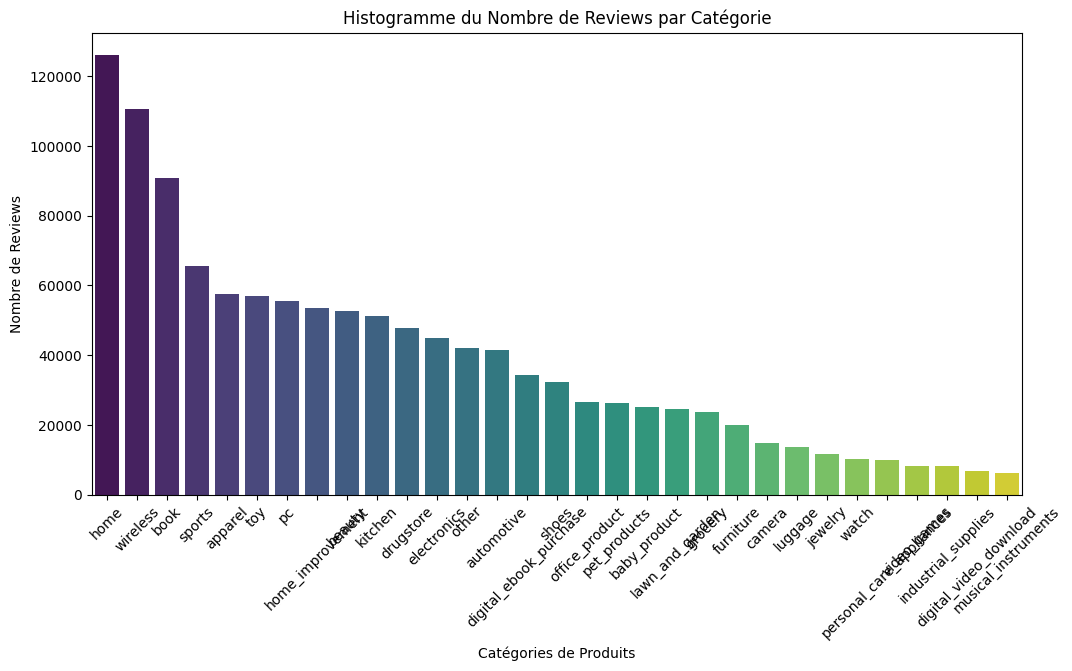

In [15]:
import seaborn as sns
# Afficher un histogramme du nombre de reviews par catégorie
# Calculer le nombre de revues par catégorie
reviews_per_category = df_train.groupby('product_category').size().sort_values(ascending=False)
# Afficher l'histogramme
plt.figure(figsize=(12, 6))
sns.barplot(x=reviews_per_category.index, y=reviews_per_category.values, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xticks(rotation=45)  # Faire pivoter les étiquettes de l'axe des x pour plus de lisibilité
plt.xlabel('Catégories de Produits')
plt.ylabel('Nombre de Reviews')
plt.title('Histogramme du Nombre de Reviews par Catégorie')
plt.show()

## Preprocessing niveau mot

Effectuez une tokenisation simple sur le body de la review en utilisant l'espace comme séparateur entre les mots. Mettez le résultat dans une nouvelle colonne de la DataFrame.

Exemple : "Samedi, je n'ai rien de prévu" -> ["Samedi", "je", "n'ai", "rien",
"de", "prévu"]

Conseil : utiliser la fonction apply de pandas

In [16]:
# Tokeniser le titre des reviews
df_train['title_tok'] = df_train['review_title'].apply(lambda x: x.split() if isinstance(x, str) else [])
# Tokeniser le corps des reviews
df_train['body_tok'] = df_train['review_body'].apply(lambda x: x.split() if isinstance(x, str) else [])

df_train['title_tok']
df_train['body_tok']


,body_tok
0,"[Armband, ist, leider, nach, 1, Jahr, kaputt, ..."
1,"[In, der, Lieferung, war, nur, Ein, Akku!]"
2,"[Ein, Stern,, weil, gar, keine, geht, nicht., ..."
3,"[Dachte,, das, wären, einfach, etwas, festere,..."
4,"[Meine, Kinder, haben, kaum, damit, gespielt, ..."
...,...
1199995,[买的时候做活动很便宜，效果真是不错，据说是纯天然的，非常滋润。]
1199996,[从生活的小细节入手，虽然已经过了时代，但是很多细节还是值得我们学习]
1199997,[速度快，质量也好，书的内容新颖，题目还有解析，是一本值得推荐的复习参考书。]
1199998,[第一次用这么好的卡，LOL能开到300多FPS]


Affichez le nombre moyen de mots dans le body d'une review

In [17]:
# Compter le nombre de mots dans chaque corps de review tokenisé
df_train['body_word_count'] = df_train['body_tok'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Calculer la moyenne du nombre de mots dans le corps des reviews
mean_body_word_count = df_train['body_word_count'].mean()

# Afficher le résultat
print(f"Nombre moyen de mots dans le corps d'une review : {mean_body_word_count}")


Nombre moyen de mots dans le corps d'une review : 21.210321666666665


Visualisez, sous forme d'histogramme, la distribution du nombre de mots dans une review

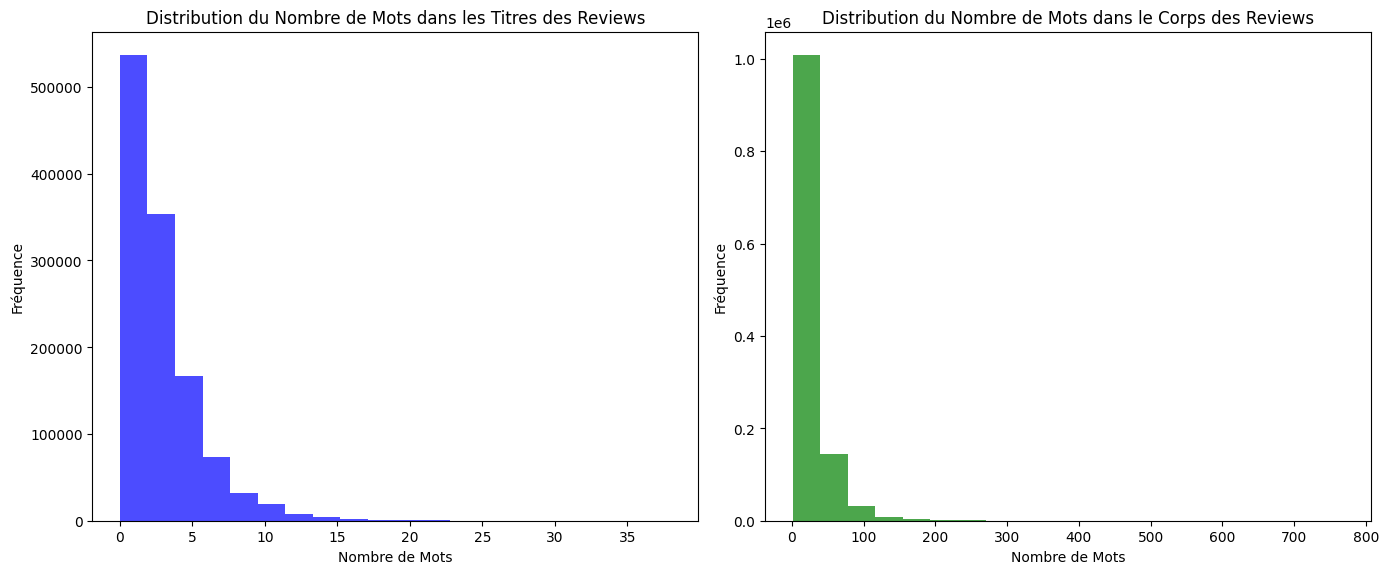

In [18]:
# Calculer le nombre de mots dans les titres et les corps
df_train['title_word_count'] = df_train['title_tok'].apply(len)
df_train['body_word_count'] = df_train['body_tok'].apply(len)

# Configuration de la taille de la figure
plt.figure(figsize=(14, 6))

# Histogramme pour le nombre de mots dans les titres
plt.subplot(1, 2, 1)
plt.hist(df_train['title_word_count'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution du Nombre de Mots dans les Titres des Reviews")
plt.xlabel("Nombre de Mots")
plt.ylabel("Fréquence")

# Histogramme pour le nombre de mots dans les corps de reviews
plt.subplot(1, 2, 2)
plt.hist(df_train['body_word_count'], bins=20, color='green', alpha=0.7)
plt.title("Distribution du Nombre de Mots dans le Corps des Reviews")
plt.xlabel("Nombre de Mots")
plt.ylabel("Fréquence")

# Ajuster l'espacement
plt.tight_layout()

# Afficher les histogrammes
plt.show()

Tokenisez le texte en utilisant le TreebankWordTokenizer de nltk et la tokenization spacy et assigner chacune à une colonne de la dataframe.  

Afficher quelques exemples afin de voir la différence entre les différents algorithmes.

In [19]:
nlp = spacy.load("fr_core_news_md")
tokenizer = nlp.tokenizer

# Fonction qui tokenize avec le tokenizer TreeBank
def treebank_tokenize(text):
    # Utilisation du TreebankWordTokenizer de NLTK
    tb_tokenizer = TreebankWordTokenizer()
    return tb_tokenizer.tokenize(text)

# Fonction qui tokenize avec le tokenizer spacy
def spacy_tokenize(text):
    # Tokenisation avec spaCy
    doc = tokenizer(text)
    return [token.text for token in doc]

# Exemple de DataFrame


# Appliquer les fonctions de tokenisation
if 'review_body' in df_train.columns:
    df_train['body_spacy_tok'] = df_train['review_body'].head(10).apply(spacy_tokenize)
    df_train['body_treebank_tok'] = df_train['review_body'].head(10).apply(treebank_tokenize)

if 'review_title' in df_train.columns:
    df_train['title_treebank_tok'] = df_train['review_title'].head(10).apply(treebank_tokenize)
    df_train['title_spacy_tok'] = df_train['review_title'].head(10).apply(spacy_tokenize)


# Afficher quelques exemples
print("Exemples de Tokenisation :")
print(df_train[['title_treebank_tok', 'title_spacy_tok']])
print("\nExemples de Tokenisation pour le corps des reviews :")
print(df_train[['body_treebank_tok', 'body_spacy_tok']])

Exemples de Tokenisation :
                          title_treebank_tok  \
0            [Leider, nach, 1, Jahr, kaputt]   
1        [EINS, statt, ZWEI, Akkus, !, !, !]   
2                         [Achtung, Abzocke]   
3                     [Zu, viel, des, Guten]   
4                 [Qualität, sehr, schlecht]   
...                                      ...   
1199995                                  NaN   
1199996                                  NaN   
1199997                                  NaN   
1199998                                  NaN   
1199999                                  NaN   

                             title_spacy_tok  
0            [Leider, nach, 1, Jahr, kaputt]  
1        [EINS, statt, ZWEI, Akkus, !, !, !]  
2                         [Achtung, Abzocke]  
3                     [Zu, viel, des, Guten]  
4                 [Qualität, sehr, schlecht]  
...                                      ...  
1199995                                  NaN  
1199996             

In [20]:
# Ajout des colonnes pour les différentes méthodes de tokenisation
df_train["body_naive_tok"] = df_train["review_body"].head(100).apply(lambda x: x.split())  # Tokenisation naïve avec espace
df_train["body_treebank_tok"] = df_train["review_body"].head(100).apply(treebank_tokenize)  # Tokenisation avec Treebank
df_train["body_spacy_tok"] = df_train["review_body"].head(100).apply(spacy_tokenize)  # Tokenisation avec spaCy

Calculez le nombre moyen de tokens pour chaque méthode de tokenisation (naive, treebank, spacy).  
Affichez quelques exemples afin de comprendre la différence dans les tokenisers.

In [21]:
# Calcul des moyennes
mean_naive = df_train["body_naive_tok"].dropna().apply(len).mean()
mean_treebank = df_train["body_treebank_tok"].dropna().apply(len).mean()
mean_spacy = df_train["body_spacy_tok"].dropna().apply(len).mean()

# Affichage des résultats
print("Naive")
print(f"Nombre moyen de mots dans le corps d'une review : {mean_naive:.2f}")

print("Treebank")
print(f"Nombre moyen de mots dans le corps d'une review : {mean_treebank:.2f}")

print("Spacy")
print(f"Nombre moyen de mots dans le corps d'une review : {mean_spacy:.2f}")

Naive
Nombre moyen de mots dans le corps d'une review : 30.96
Treebank
Nombre moyen de mots dans le corps d'une review : 33.70
Spacy
Nombre moyen de mots dans le corps d'une review : 35.40


On peut afficher quelques exemples de tokenisation pour comparer les algorithmes

In [22]:
i = 2
df_tmp = df_train.reset_index()
print(f"original text : {df_tmp.loc[i]['review_body']}")
print(f"naive         : {df_tmp.loc[i]['body_naive_tok']}")
print(f"treebank      : {df_tmp.loc[i]['body_treebank_tok']}")
print(f"spacy         : {df_tmp.loc[i]['body_spacy_tok']}")

original text : Ein Stern, weil gar keine geht nicht. Es handelt sich um gebraucht Waren, die Stein haben so ein Belag drauf, wo man sich dabei denken kann, dass jemand schon die benutzt und nicht Mal richtig gewaschen. Bei ein paar ist die Qualität Mangelhaft, siehe Bild. Ein habe ich ausprobiert, richtig gewaschen, dann verfärbt sich..... Wärme halt nicht lange. Deswegen wird es zurückgeschickt.
naive         : ['Ein', 'Stern,', 'weil', 'gar', 'keine', 'geht', 'nicht.', 'Es', 'handelt', 'sich', 'um', 'gebraucht', 'Waren,', 'die', 'Stein', 'haben', 'so', 'ein', 'Belag', 'drauf,', 'wo', 'man', 'sich', 'dabei', 'denken', 'kann,', 'dass', 'jemand', 'schon', 'die', 'benutzt', 'und', 'nicht', 'Mal', 'richtig', 'gewaschen.', 'Bei', 'ein', 'paar', 'ist', 'die', 'Qualität', 'Mangelhaft,', 'siehe', 'Bild.', 'Ein', 'habe', 'ich', 'ausprobiert,', 'richtig', 'gewaschen,', 'dann', 'verfärbt', 'sich.....', 'Wärme', 'halt', 'nicht', 'lange.', 'Deswegen', 'wird', 'es', 'zurückgeschickt.']
treebank   

### Loi de Zipf

Nous allez vérifier si la loi de Zipf est applicable dans notre corpus. Pour rappel :  
$$ f(r) \propto { 1 \over r }$$
où $f(r)$ est la fréquence d'apparition du mot de rang $r$ du corpus.


Commencez par calculer le nombre d'apparition de chaque mot dans le corpus (vous pouvez utiliser la tokenisation spacy)

Conseil :  
* Utiliser la structure de donnée Counter du package collections  
* Construisez une DataFrame où chaque ligne contient un mot/token et son nombre d'apparitions

In [23]:
from collections import Counter
df_train['body_spacy_tok'] = df_train['body_spacy_tok'].apply(lambda x: x if isinstance(x, list) else [])
flattened_text = [token for sublist in df_train['body_spacy_tok'] for token in sublist]
counter =  Counter(flattened_text) # On utilise le counter pour compter le nombre d'apparition de chaque mot

df_zipf =pd.DataFrame(counter.items(), columns=['word', 'occurrences']) # On construit une dataframe contenant le nombre d'occurences pour chaque token
df_zipf

,word,occurrences
0,Armband,1
1,ist,53
2,leider,14
3,nach,23
4,1,1
...,...,...
1245,warte,1
1246,Rückerstattung,1
1247,Ansonsten,1
1248,Rechtsmittel,1


Calculez ensuite la fréquence d'apparition de chaque token en normalisant par le nombre total de tokens.

In [24]:
# Étape 1 : Calculer le nombre total de tokens dans le corpus
nb_total = df_zipf['occurrences'].sum()

# Étape 2 : Calculer la fréquence de chaque token
df_zipf['freq'] = df_zipf['occurrences'] / nb_total

# Étape 3 : Trier les valeurs de fréquence par ordre décroissant
df_zipf = df_zipf.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_zipf

,word,occurrences,freq
0,.,214,0.060452
1,",",104,0.029379
2,nicht,93,0.026271
3,und,59,0.016667
4,!,57,0.016102
...,...,...,...
1245,beziehungsweise,1,0.000282
1246,bewirken,1,0.000282
1247,sollten,1,0.000282
1248,Offensichtlich,1,0.000282


Affichez sur un graphe la fréquence des mots en fonction de leur rang  

Attention :  
* Triez d'abord les fréquences par ordre décroissant  
* Utilisez une échelle log-log sur les abscisses et les ordonnées  

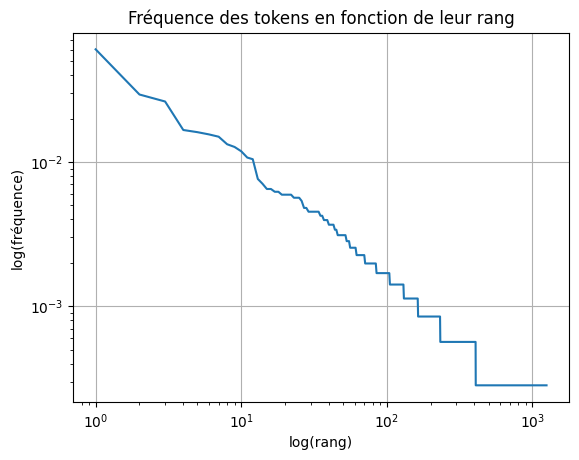

In [25]:
plt.figure()
plt.grid()
plt.xscale('log')  # On utilise une échelle log-log
plt.yscale('log')  # Using log scale
plt.xlabel('log(rang)')
plt.ylabel('log(fréquence)')
x = list(range(1,df_zipf.shape[0]+1)) # mes rangs sont 0, 1, 2, ...
y=df_zipf['freq']
plt.title("Fréquence des tokens en fonction de leur rang")
plt.plot(x,y)
plt.show()

# Classification

Nous allons à présent utiliser une représentation Bag of Words afin d'entraîner un modèle simple pour faire de la classification de sentiments.  

La représentation Bag of Words (BoW) consiste à considérer un document comme un ensemble de tokens sans prendre en compte leur ordre dans le document. En somme, on compte le nombre d'apparition de chaque token du vocabulaire dans le document.  

Exemple pour la phrase:  
`"Je pense donc je suis"` tokénizée en `["je", "pense", "donc", "je", "suis"]`, la réprésentation BoW sous forme de dictionnaire est :  
```
{
  "je": 2,
  "pense": 1,
  "donc": 1,
  "suis": 1
}
```
En pratique, c'est une représentation vectorielle qui est utilisée. Un document $d$ serait représenté ainsi:  
$$d = [n_1, n_2, ..., n_V]$$
où $n_i$ est le nombre d'apparition du $i$ème token du vocabulaire et $V$ la taille de ce dernier.  

La tâche de classification/analyse de sentiment consiste à classifier le sentiment exprimé par un document. Ceci peut se présenter sous plusieurs formes
* On donne un score entre -1 (négatif) et +1 (positif)  
* On classifie entre deux ou trois sentiments : négatif, neutre, positif  
* On détecte l'émotion exprimée (joie, peur, colère, ...)  
* ...  

Nous allons utiliser le dataset d'avis amazon qui contient la note donnée dans chaque review au produit. Par souci de simplicité, nous allons transformer la note donnée (entre 1 et 5) en deux classes:  
* 0 : quand la note est entre 1 et 3 pour exprimer un sentiment négatif  
* 1 : quand la note est entre 4 et 5 pour exprimer un sentiment positif  

L'objectif étant de faire l'apprentissage d'un modèle sur le split de train pour ensuite l'évaluer sur le split de test.



On commence par créer la colonne sentiment qui sera calculée à partir de la colonne stars

In [26]:

df_train["sentiment"] = df_train["stars"].apply(lambda x: 1 if x >= 4 else 0)
df_test["sentiment"] = df_test["stars"].apply(lambda x: 1 if x >= 4 else 0)


On effectue une tokenisation du texte (pour les deux splits train et test) avec spacy (idem que pour la section précédente)

In [27]:
# Charger le modèle spaCy en désactivant certaines fonctionnalités
nlp = spacy.load("fr_core_news_md", disable=["parser", "ner", "attribute_ruler", "tok2vec"])
tokenizer = nlp.tokenizer

# Fonction pour tokenizer avec spaCy
def spacy_tokenize(text):
    """
    Tokenise un texte en utilisant le tokenizer de spaCy.
    Cette version utilise un modèle spaCy optimisé pour des performances plus rapides.
    """
    doc = nlp(text)  # Crée un objet spaCy 'doc' en utilisant la version optimisée de spacy
    return [token.text for token in doc]  # Retourne la liste des tokens textuels


In [28]:
# Appliquer la fonction spacy_tokenize à la colonne "review_body" du train dataset
df_train["body_spacy"] = df_train["review_body"].apply(spacy_tokenize)

# Appliquer la fonction spacy_tokenize à la colonne "review_body" du test dataset
df_test["body_spacy"] = df_test["review_body"].apply(spacy_tokenize)


On utilise ensuite le CountVectorizer de sklearn afin de calcul la représentation Bag of Words de chaque document des deux splits.  

Note : Utilisez les paramètres suivants dans l'instanciation du CounterVectorizer afin de ne pas utiliser le préprocesseur et le tokenizer de sklearn:
```
tokenizer=lambda x:x,
preprocessor=lambda x:x,
```

Attention : Utilisez la fonction transform sur la dataset de test afin de garder le même vocabulaire sur lequel le CountVectorizer a été construit (sur le dataset de train)  

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Créer le CountVectorizer
count_vec = CountVectorizer()

# "Fitter" le CountVectorizer sur les données textuelles (ici la colonne "review_body" tokenisée avec spaCy)
count_vec.fit(df_train["body_spacy"].apply(lambda x: ' '.join(x)))

# Calculer la représentation Bag of Words du dataset de train
bow_train = count_vec.transform(df_train["body_spacy"].apply(lambda x: ' '.join(x)))


Affichez la taille du vecteur bag of words calculé. Que constatez-vous ?

In [30]:
X_train = bow_train
y_train = df_train["sentiment"]

Lancez l'apprentissage d'un modèle de classification Naive Bayes sur le split d'apprentissage. Utilisez pour cela la classe MultinomialNB de sklearn.

In [31]:
from sklearn.naive_bayes import MultinomialNB

# Créer une instance du modèle Multinomial Naive Bayes
model = MultinomialNB()

# Entraîner le modèle sur le dataset d'apprentissage (BoW et la colonne 'sentiment')
model.fit(bow_train, df_train["sentiment"])


MultinomialNB()

Une fois le modèle entraîné, nous allons l'évaluer. Utilisez la fonction predict sur votre dataset de test afin d'obtenir ses prédictions.

In [32]:

bow_test = count_vec.transform(df_test["body_spacy"].apply(lambda x: ' '.join(x)))

# Définir X_test et y_test
X_test = bow_test
y_test = df_test["sentiment"]

In [33]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 1])

Calculez les performances du modèle (Accuracy, F1_score, Precision, Rappel) en utilisant les fonctions présentes dans `sklearn.metrics`.  
Pour cela on compare la prédiction faite précédement aux vraies classes (ground truth ou vérité terrain).

In [34]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
# On calcule les performances du modèle sur le dataset de test
accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")

Accuracy: 0.7508
F1 Score: 0.6858
Precision: 0.8094
Rappel: 0.5949


# Topic modeling

Dans cette section, nous allons utiliser le modèle LDA afin d'extraire les thématiques (topics) présents dans le corpus *20 newsgroups*.  
Le modèle LDA prend en entrée les documents d'un corpus et, en utilisant la co-occurence des mots. Donne en sortie une liste de **topics** et l'assignation de chaque document à ces topics.  
* Un **topic** est en faite une distribution des mots sur le vocabulaire. Par exemple, dans un topic concernant l'astronomie, le modèle assignerait une grande probabilités à des mots comme planète, espace, galaxie, astronaute, ...  
* Chaque document est aussi décrit comme une distribution sur les topics. Un article de journal pourrait alors appartenir à 60% au topic sport, 30% au topic santé et 10% au topic politique.  

Pour effectuer cette tâche, nous allons utiliser le package gensim. Nous effectuerons le topic modeling sans et avec preprocessing pour comparer les résultats.

In [35]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import spacy
import nltk
from tqdm import tqdm
tqdm.pandas()

On charge le modèle 20 newsgroups qui comporte 18000 posts dans des groupes usenet (forum) sur 20 sujets. Nous n'utiliserons que le split de train.

In [36]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [37]:
df_news = pd.DataFrame({
    "text": newsgroups_train.data,
    "class": newsgroups_train.target
})


On tokenise le texte selon deux approches, sans preprocessings (`spacy_tokenize`) et avec preprocessings (`spacy_clean`). Les preprocessings sont les suivants :  
* Mettre le texte en minuscule  
* Lemmatiser le texte  
* Supprimer les stopwords (the, these, a, is, are, ...)  
* Ne garder que les tokens de plus de 2 caractères  
* Ne garder que les tokens qui sont alphabétiques

In [38]:
nlp = spacy.load("en_core_web_md", disable=["parser", "ner", "tok2vec"])
tokenizer = nlp.tokenizer

def spacy_tokenize(text):
  text_tokenized = tokenizer(text)
  return list(map(str, text_tokenized))

def spacy_preprocess(text):
    # Application des traitements avec le modèle nlp de spacy
    doc = nlp(text)

    # Preprocessing :
    # Lemmatisation, suppression des stopwords, suppression des tokens courts (2 caractères ou moins),
    # suppression des tokens non alphabétiques, transformation en minuscules
    text_clean = [
        token.lemma_.lower() for token in doc
        if not token.is_stop                      # Suppression des stopwords
        and len(token) > 2                        # Suppression des tokens courts
        and token.is_alpha                        # Suppression des tokens non alphabétiques
    ]

    return text_clean

In [39]:
# On appliquer les deux preprocessings
df_news["text_tokenized"] = df_news["text"].progress_apply(spacy_tokenize)
df_news["text_preprocessed"] = df_news["text"].progress_apply(spacy_preprocess)

100%|██████████| 11314/11314 [03:27<00:00, 54.45it/s]


On commence par effectuer un topic modeling sur la partie non processée du texte (spacy_tokenize)

On calcule un dictionnaire permettant d'assigner un entier à chaque token du vocabulaire.  

On construit ensuite un corpus encodé en utilisant ce dictionnaire.

Conseil : Voir la documentation ou des exemples sur internet

In [40]:
from gensim import corpora


# On construit le dictionnaire
dictionary_tok = corpora.Dictionary(df_news["text_tokenized"])
# On construit le corpus encodé avec le dictionnaire
corpus_tok = [dictionary_tok.doc2bow(tokens) for tokens in df_news["text_tokenized"]]

In [41]:
print(f"Taille du dictionnaire (taille du vocabulaire) : {len(dictionary_tok.keys())}")
print(f"Exemple du dictionnaire : {dictionary_tok[51]}")

Taille du dictionnaire (taille du vocabulaire) : 172169
Exemple du dictionnaire : can


On fait la même chose pour la version preprocessée du texte (spacy_preprocess)

In [42]:
# On construit le dictionnaire
dictionary_preproc = corpora.Dictionary(df_news["text_preprocessed"])
corpus_preproc = [dictionary_preproc.doc2bow(tokens) for tokens in df_news["text_preprocessed"]]


In [43]:
print(f"Taille du dictionnaire (taille du vocabulaire) : {len(dictionary_preproc.keys())}")
print(f"Exemple du dictionnaire : {dictionary_preproc[51]}")

Taille du dictionnaire (taille du vocabulaire) : 65970
Exemple du dictionnaire : attained


On remarque que le vocabulaire est beaucoup plus petit avec le preprocessing.

On crée le modèle et on lance son "apprentissage" en lui indiquant un nombre de topics de 20.

In [44]:
from gensim.models import LdaModel
# Nombre de topics que vous souhaitez trouver
num_topics = 20

# On lance l'apprentissage du modèle LDA
ldamodel_tok = LdaModel(
    corpus=corpus_preproc,
    num_topics=num_topics,
    id2word=dictionary_preproc,
    passes=15,  # Nombre de passes sur le corpus
    random_state=42  # Pour la reproductibilité
)

In [45]:
num_topics = 20

# On lance l'apprentissage du modèle LDA
ldamodel_preproc = LdaModel(
    corpus=corpus_preproc,  # Le corpus prétraité
    num_topics=num_topics,  # Nombre de topics
    id2word=dictionary_preproc,  # Le dictionnaire
    passes=15,  # Nombre de passes sur le corpus
    random_state=42  # Pour la reproductibilité
)

On affiche les 10 mots les plus représentatifs de chacun des 20 topics.

In [46]:
ldamodel_tok.show_topics(
    num_topics=20,
    num_words=10
)

[(0,
  '0.008*"health" + 0.007*"medical" + 0.006*"food" + 0.005*"disease" + 0.005*"years" + 0.004*"use" + 0.004*"pain" + 0.004*"water" + 0.004*"research" + 0.004*"patients"'),
 (1,
  '0.020*"keith" + 0.018*"morality" + 0.017*"jon" + 0.016*"objective" + 0.012*"moral" + 0.011*"system" + 0.009*"van" + 0.009*"bos" + 0.008*"det" + 0.007*"writes"'),
 (2,
  '0.011*"writes" + 0.011*"like" + 0.011*"subject" + 0.011*"article" + 0.011*"car" + 0.010*"lines" + 0.010*"organization" + 0.006*"know" + 0.005*"time" + 0.005*"good"'),
 (3,
  '0.036*"space" + 0.014*"nasa" + 0.010*"earth" + 0.009*"moon" + 0.008*"orbit" + 0.008*"launch" + 0.006*"lunar" + 0.006*"shuttle" + 0.006*"georgia" + 0.006*"data"'),
 (4,
  '0.010*"islamic" + 0.010*"theory" + 0.010*"mouse" + 0.009*"rice" + 0.009*"fred" + 0.008*"risc" + 0.008*"gregg" + 0.008*"rushdie" + 0.007*"deskjet" + 0.007*"canon"'),
 (5,
  '0.027*"key" + 0.014*"encryption" + 0.013*"chip" + 0.012*"clipper" + 0.010*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"gove

In [47]:
ldamodel_preproc.show_topics(
    num_topics=20,
    num_words=10
)

[(0,
  '0.008*"health" + 0.007*"medical" + 0.006*"food" + 0.005*"disease" + 0.005*"years" + 0.004*"use" + 0.004*"pain" + 0.004*"water" + 0.004*"research" + 0.004*"patients"'),
 (1,
  '0.020*"keith" + 0.018*"morality" + 0.017*"jon" + 0.016*"objective" + 0.012*"moral" + 0.011*"system" + 0.009*"van" + 0.009*"bos" + 0.008*"det" + 0.007*"writes"'),
 (2,
  '0.011*"writes" + 0.011*"like" + 0.011*"subject" + 0.011*"article" + 0.011*"car" + 0.010*"lines" + 0.010*"organization" + 0.006*"know" + 0.005*"time" + 0.005*"good"'),
 (3,
  '0.036*"space" + 0.014*"nasa" + 0.010*"earth" + 0.009*"moon" + 0.008*"orbit" + 0.008*"launch" + 0.006*"lunar" + 0.006*"shuttle" + 0.006*"georgia" + 0.006*"data"'),
 (4,
  '0.010*"islamic" + 0.010*"theory" + 0.010*"mouse" + 0.009*"rice" + 0.009*"fred" + 0.008*"risc" + 0.008*"gregg" + 0.008*"rushdie" + 0.007*"deskjet" + 0.007*"canon"'),
 (5,
  '0.027*"key" + 0.014*"encryption" + 0.013*"chip" + 0.012*"clipper" + 0.010*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"gove

On constate que sans preprocessings, on obtient des topics avec beaucoup de bruit.



On peut visualiser les topics avec l'outil pyLDAvis

In [48]:
pip install pyLDAvis

In [49]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(ldamodel_preproc, corpus_preproc, dictionary_preproc)
pyLDAvis.display(lda_display)